# MARBERT v2 Fine-tuning Round 3: Multi-Seed Validation

This notebook validates the best configuration with multiple random seeds to measure variance.

**Best Configuration from Round 2**: Config 6 (Winner + 4 Epochs) - **83.76% F1**

**Problem Identified**: High variance between runs
- Round 1 winner config (2e-5, 3 epochs): **83.76% F1**
- Same config in Round 2: **81.41% F1**
- **Variance: ±2.35%** - unreliable for comparing configs!

**This Round**: Test best config with 5 random seeds
- Seeds: 42, 43, 44, 45, 46
- Calculate mean and std dev of F1 scores
- Get reliable performance estimate

**Configuration**: 4 epochs, LR=2e-5, basic preprocessing

**Model**: MARBERT v2 (UBC-NLP/MARBERTv2)

**Goal**: Determine true performance with confidence intervals

## Setup: Install Required Packages

In [1]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate -q

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## Load Dataset (Basic Preprocessing)

In [3]:
# Load basic preprocessing dataset
# Note: Update the path if running on Colab and data is uploaded
basic_path = 'arb_clean_basic.csv'

df_basic = pd.read_csv(basic_path)

print("="*80)
print("BASIC PREPROCESSING DATASET")
print("="*80)
print(f"Shape: {df_basic.shape}")
print(f"Columns: {list(df_basic.columns)}")
print(f"\nClass distribution:")
print(df_basic['polarization'].value_counts())
print(f"Class balance: {df_basic['polarization'].value_counts(normalize=True).to_dict()}")

BASIC PREPROCESSING DATASET
Shape: (3380, 3)
Columns: ['id', 'text', 'polarization']

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64
Class balance: {0: 0.5526627218934911, 1: 0.44733727810650886}


## Helper Functions for Training and Evaluation

In [4]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def evaluate_model(trainer, test_dataset, seed):
    """Evaluate model and return detailed metrics"""
    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    return {
        'seed': seed,
        'accuracy': accuracy,
        'f1': f1,
        'confusion_matrix': cm,
        'true_labels': labels,
        'pred_labels': preds
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## Best Configuration

Using the winner from Round 2: 4 epochs, LR=2e-5, basic preprocessing

In [5]:
# Best configuration from Round 2
best_config = {
    'name': 'Best Config: 4 Epochs, LR=2e-5',
    'num_train_epochs': 4,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 32,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.01,
}

# Random seeds to test
random_seeds = [42, 43, 44, 45, 46]

print("Configuration:")
print("="*80)
for key, value in best_config.items():
    if key != 'name':
        print(f"  {key}: {value}")
print("\nRandom seeds to test:", random_seeds)
print(f"Total runs: {len(random_seeds)}")
print("="*80)

Configuration:
  num_train_epochs: 4
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 2e-05
  warmup_steps: 500
  weight_decay: 0.01

Random seeds to test: [42, 43, 44, 45, 46]
Total runs: 5


## Train and Evaluate with Multiple Seeds

Train the same configuration 5 times with different random seeds

In [6]:
# Model name
model_name = "UBC-NLP/MARBERTv2"

# Store all results
all_results = []

print("\n" + "="*80)
print(f"Training MARBERT v2 with {len(random_seeds)} different random seeds")
print("="*80)

for seed in random_seeds:
    print(f"\n{'='*80}")
    print(f"Training with Random Seed: {seed}")
    print(f"{'='*80}")

    # Split dataset with current seed
    train_df, test_df = train_test_split(
        df_basic,
        test_size=0.1,
        random_state=seed,
        stratify=df_basic['polarization']
    )

    print(f"\nDataset split (seed={seed}):")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Test: {len(test_df)} samples")

    # Convert to HuggingFace Dataset
    train_dataset = Dataset.from_pandas(train_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))
    test_dataset = Dataset.from_pandas(test_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))

    # Load fresh model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize datasets
    tokenized_train = train_dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True
    )
    tokenized_test = test_dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True
    )

    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_r3_seed{seed}',
        num_train_epochs=best_config['num_train_epochs'],
        per_device_train_batch_size=best_config['per_device_train_batch_size'],
        per_device_eval_batch_size=best_config['per_device_eval_batch_size'],
        learning_rate=best_config['learning_rate'],
        warmup_steps=best_config['warmup_steps'],
        weight_decay=best_config['weight_decay'],
        logging_dir=f'./logs_r3_seed{seed}',
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=seed
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train
    print(f"\nTraining with seed {seed}...")
    trainer.train()

    # Evaluate
    results = evaluate_model(trainer, tokenized_test, seed)
    all_results.append(results)

    print(f"\nResults (seed={seed}):")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  F1 Score: {results['f1']:.4f}")

    # Clear GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()

print("\n" + "="*80)
print("ALL TRAINING COMPLETED!")
print("="*80)


Training MARBERT v2 with 5 different random seeds

Training with Random Seed: 42

Dataset split (seed=42):
  Train: 3042 samples
  Test: 338 samples


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training with seed 42...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nuh-alsharafi (deepclean415445) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.680900,0.426922,0.810651,0.809695
2,0.388600,0.379248,0.816568,0.817065
3,0.272900,0.455209,0.822485,0.822686
4,0.129900,0.766293,0.807692,0.808158



Results (seed=42):
  Accuracy: 0.8225
  F1 Score: 0.8227

Training with Random Seed: 43

Dataset split (seed=43):
  Train: 3042 samples
  Test: 338 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training with seed 43...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682500,0.429659,0.807692,0.808158
2,0.394700,0.358218,0.846154,0.846328
3,0.265900,0.406615,0.843195,0.841927
4,0.129100,0.628583,0.852071,0.852160



Results (seed=43):
  Accuracy: 0.8521
  F1 Score: 0.8522

Training with Random Seed: 44

Dataset split (seed=44):
  Train: 3042 samples
  Test: 338 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training with seed 44...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.680800,0.442365,0.807692,0.806402
2,0.388800,0.385756,0.837278,0.837420
3,0.265800,0.530189,0.822485,0.820935
4,0.138300,0.620834,0.831361,0.831828



Results (seed=44):
  Accuracy: 0.8373
  F1 Score: 0.8374

Training with Random Seed: 45

Dataset split (seed=45):
  Train: 3042 samples
  Test: 338 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training with seed 45...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.683500,0.448296,0.795858,0.794488
2,0.419200,0.339147,0.846154,0.846586
3,0.281900,0.338060,0.866864,0.867214
4,0.133300,0.508021,0.860947,0.861068



Results (seed=45):
  Accuracy: 0.8669
  F1 Score: 0.8672

Training with Random Seed: 46

Dataset split (seed=46):
  Train: 3042 samples
  Test: 338 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training with seed 46...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.672100,0.421212,0.816568,0.817065
2,0.380800,0.376302,0.810651,0.810523
3,0.248600,0.497021,0.784024,0.784408
4,0.128300,0.771916,0.810651,0.810765



Results (seed=46):
  Accuracy: 0.8166
  F1 Score: 0.8171

ALL TRAINING COMPLETED!


## Statistical Analysis of Results

In [7]:
# Create results DataFrame
results_df = pd.DataFrame([
    {
        'Seed': r['seed'],
        'Accuracy': r['accuracy'],
        'F1 Score': r['f1']
    }
    for r in all_results
])

# Calculate statistics
f1_mean = results_df['F1 Score'].mean()
f1_std = results_df['F1 Score'].std()
f1_min = results_df['F1 Score'].min()
f1_max = results_df['F1 Score'].max()
f1_range = f1_max - f1_min

acc_mean = results_df['Accuracy'].mean()
acc_std = results_df['Accuracy'].std()

# 95% confidence interval (assuming normal distribution)
ci_95 = 1.96 * f1_std / np.sqrt(len(random_seeds))

print("\n" + "="*80)
print("MULTI-SEED VALIDATION RESULTS")
print("="*80)
print("\nIndividual Results:")
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\n📊 F1 Score Statistics:")
print(f"  Mean:     {f1_mean:.4f}")
print(f"  Std Dev:  {f1_std:.4f} (±{f1_std/f1_mean*100:.2f}%)")
print(f"  Min:      {f1_min:.4f}")
print(f"  Max:      {f1_max:.4f}")
print(f"  Range:    {f1_range:.4f}")
print(f"  95% CI:   [{f1_mean - ci_95:.4f}, {f1_mean + ci_95:.4f}]")

print("\n📊 Accuracy Statistics:")
print(f"  Mean:     {acc_mean:.4f}")
print(f"  Std Dev:  {acc_std:.4f} (±{acc_std/acc_mean*100:.2f}%)")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

if f1_std < 0.01:
    print("✅ Very stable: Low variance across seeds (<1%)")
elif f1_std < 0.02:
    print("✅ Stable: Acceptable variance across seeds (1-2%)")
elif f1_std < 0.03:
    print("⚠️  Moderate variance: Results somewhat inconsistent (2-3%)")
else:
    print("❌ High variance: Results highly inconsistent (>3%)")

print(f"\n🎯 Recommended Performance Report:")
print(f"   F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"   95% CI: [{f1_mean - ci_95:.4f}, {f1_mean + ci_95:.4f}]")


MULTI-SEED VALIDATION RESULTS

Individual Results:
 Seed  Accuracy  F1 Score
   42  0.822485  0.822686
   43  0.852071  0.852160
   44  0.837278  0.837420
   45  0.866864  0.867214
   46  0.816568  0.817065

STATISTICAL SUMMARY

📊 F1 Score Statistics:
  Mean:     0.8393
  Std Dev:  0.0207 (±2.47%)
  Min:      0.8171
  Max:      0.8672
  Range:    0.0501
  95% CI:   [0.8211, 0.8575]

📊 Accuracy Statistics:
  Mean:     0.8391
  Std Dev:  0.0208 (±2.48%)

INTERPRETATION
⚠️  Moderate variance: Results somewhat inconsistent (2-3%)

🎯 Recommended Performance Report:
   F1 Score: 0.8393 ± 0.0207
   95% CI: [0.8211, 0.8575]


## Visualize Results Across Seeds

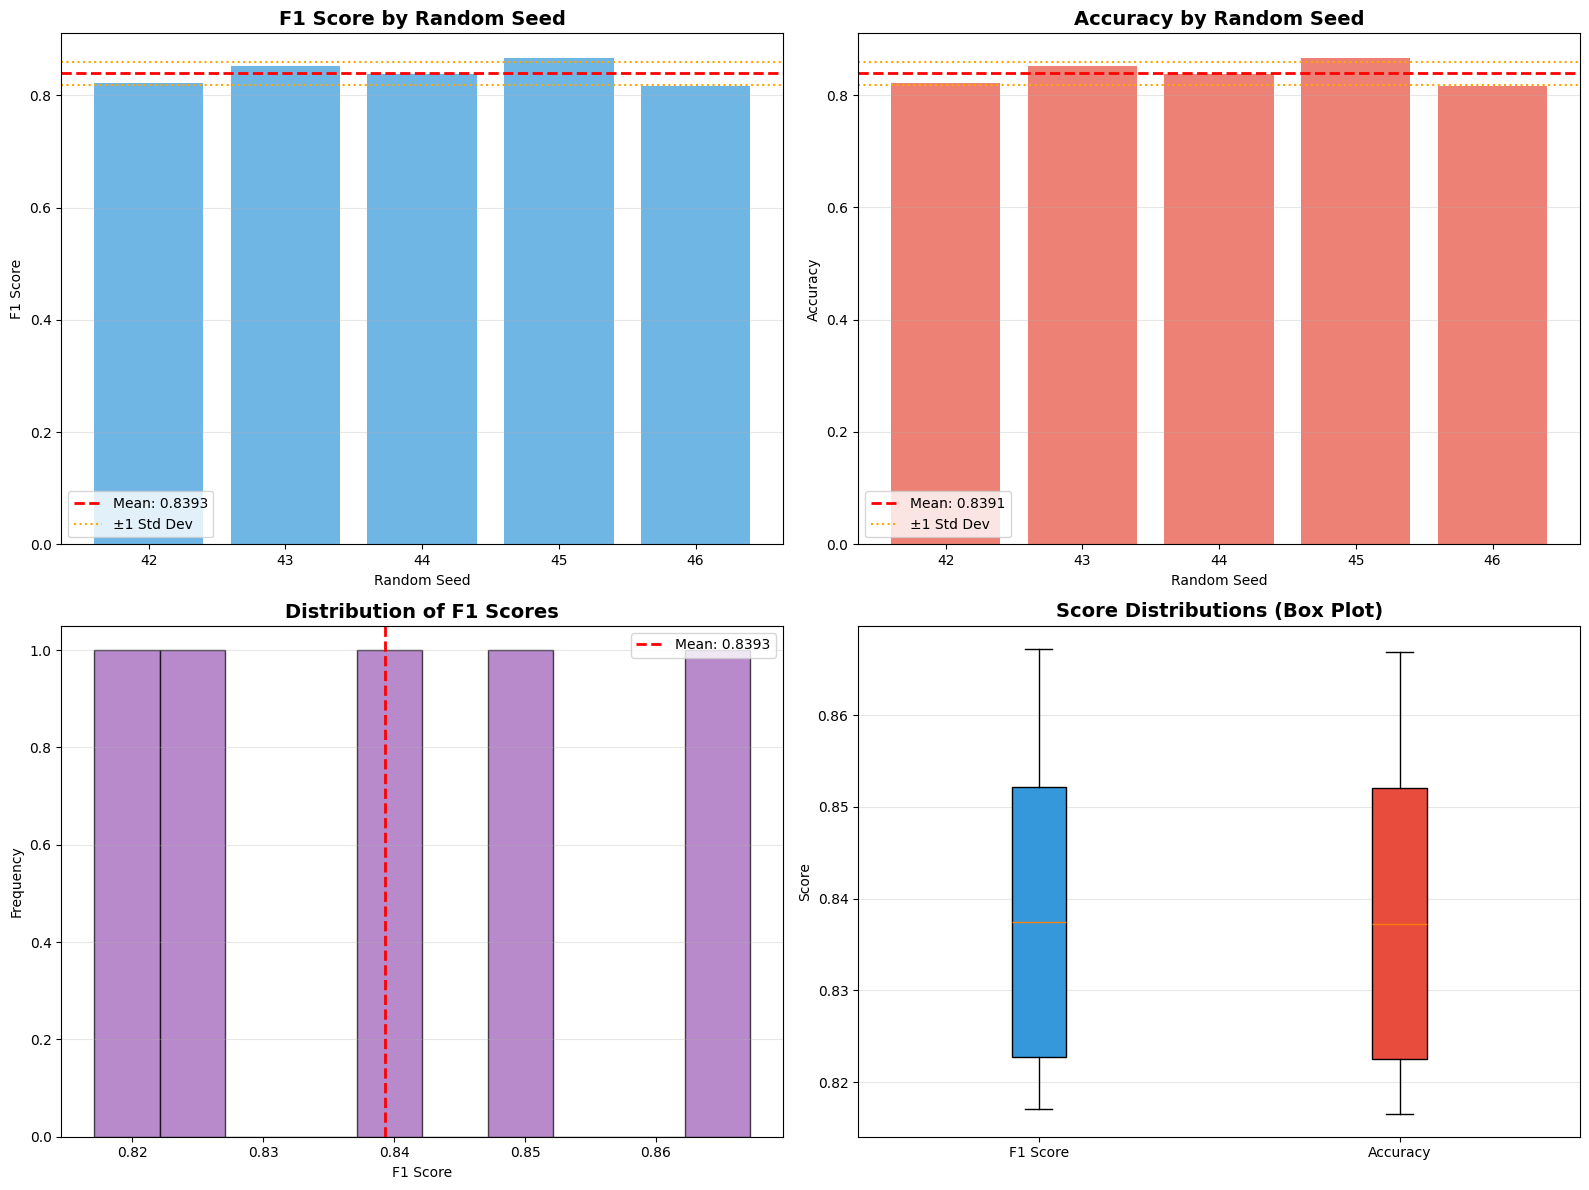


✓ Visualization complete


In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Scores by Seed
ax1 = axes[0, 0]
ax1.bar(results_df['Seed'].astype(str), results_df['F1 Score'], color='#3498db', alpha=0.7)
ax1.axhline(y=f1_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {f1_mean:.4f}')
ax1.axhline(y=f1_mean + f1_std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std Dev')
ax1.axhline(y=f1_mean - f1_std, color='orange', linestyle=':', linewidth=1.5)
ax1.set_title('F1 Score by Random Seed', fontsize=14, fontweight='bold')
ax1.set_xlabel('Random Seed')
ax1.set_ylabel('F1 Score')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Accuracy by Seed
ax2 = axes[0, 1]
ax2.bar(results_df['Seed'].astype(str), results_df['Accuracy'], color='#e74c3c', alpha=0.7)
ax2.axhline(y=acc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {acc_mean:.4f}')
ax2.axhline(y=acc_mean + acc_std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std Dev')
ax2.axhline(y=acc_mean - acc_std, color='orange', linestyle=':', linewidth=1.5)
ax2.set_title('Accuracy by Random Seed', fontsize=14, fontweight='bold')
ax2.set_xlabel('Random Seed')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Distribution of F1 Scores
ax3 = axes[1, 0]
ax3.hist(results_df['F1 Score'], bins=10, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.axvline(x=f1_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {f1_mean:.4f}')
ax3.set_title('Distribution of F1 Scores', fontsize=14, fontweight='bold')
ax3.set_xlabel('F1 Score')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Box Plot
ax4 = axes[1, 1]
bp = ax4.boxplot([results_df['F1 Score'], results_df['Accuracy']],
                  labels=['F1 Score', 'Accuracy'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
ax4.set_title('Score Distributions (Box Plot)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Confusion Matrices for All Seeds

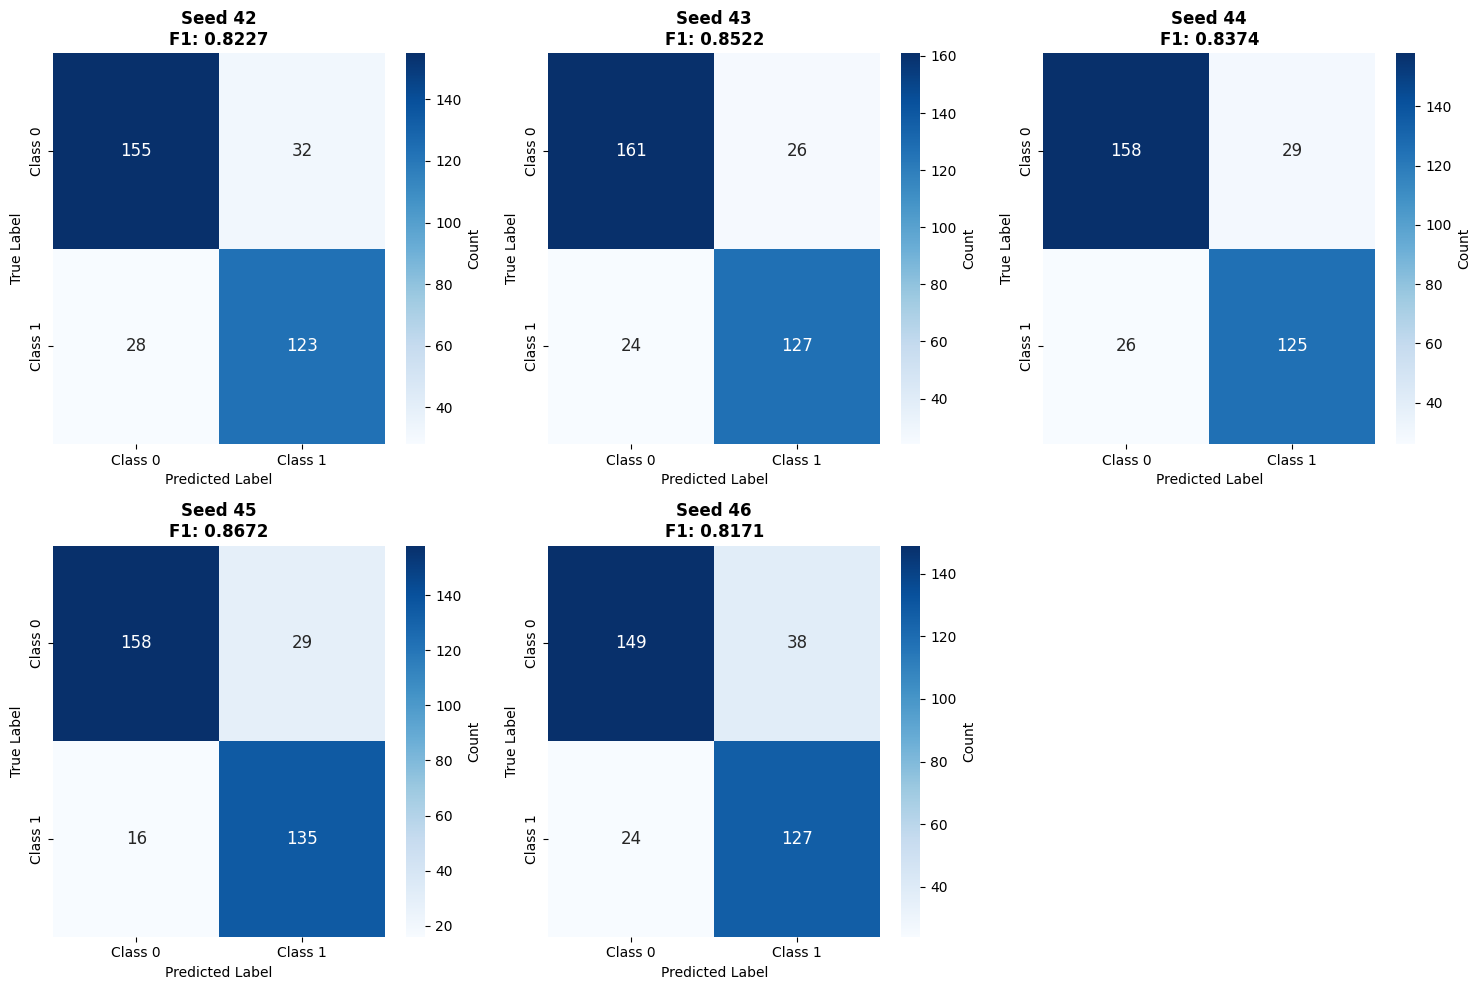


✓ Displayed 5 confusion matrices


In [9]:
# Create confusion matrices grid
n_results = len(all_results)
n_cols = 3
n_rows = (n_results + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_results > 1 else [axes]

for idx, result in enumerate(all_results):
    ax = axes[idx]
    cm = result['confusion_matrix']

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 12})

    # Set labels
    ax.set_title(f"Seed {result['seed']}\nF1: {result['f1']:.4f}",
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

# Hide any unused subplots
for idx in range(n_results, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {n_results} confusion matrices")

## Detailed Classification Reports

In [10]:
# Print classification reports for all seeds
for result in all_results:
    print("\n" + "="*80)
    print(f"Seed {result['seed']}")
    print("="*80)
    print(f"\nAccuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(result['true_labels'], result['pred_labels'],
                                target_names=['Class 0 (Negative)', 'Class 1 (Positive)']))
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])
    print(f"  [[TN={result['confusion_matrix'][0][0]}, FP={result['confusion_matrix'][0][1]}],")
    print(f"   [FN={result['confusion_matrix'][1][0]}, TP={result['confusion_matrix'][1][1]}]]")


Seed 42

Accuracy: 0.8225
F1 Score: 0.8227

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.85      0.83      0.84       187
Class 1 (Positive)       0.79      0.81      0.80       151

          accuracy                           0.82       338
         macro avg       0.82      0.82      0.82       338
      weighted avg       0.82      0.82      0.82       338


Confusion Matrix:
[[155  32]
 [ 28 123]]
  [[TN=155, FP=32],
   [FN=28, TP=123]]

Seed 43

Accuracy: 0.8521
F1 Score: 0.8522

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.87      0.86      0.87       187
Class 1 (Positive)       0.83      0.84      0.84       151

          accuracy                           0.85       338
         macro avg       0.85      0.85      0.85       338
      weighted avg       0.85      0.85      0.85       338


Confusion Matrix:
[[161  26]
 [ 24 127]]
  [[TN=161, FP